In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pathlib, os, glob
import tempfile
import numpy as np
import pyarrow.dataset as ds
from dask import delayed
from fastparquet import ParquetFile
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import dask
#import graphviz
#%load_ext line_profiler
client = Client(n_workers=8, threads_per_worker=4, memory_limit='1GB')
dask.config.set({"optimization.fuse.active": False})
client

Client Scheduler: tcp://127.0.0.1:65394 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 8.00 GB


In [2]:
geodata = pd.read_csv('state_analysis/USA-20201111T151226/data/geodata_territories_2019.csv',
                     converters={'geoid': lambda x: str(x)})

In [13]:
all_runs = {'bad':'state-runs/bad/USA/inference/med/2021.01.12.16:31:54./global/intermediate/',
            'good':'state-runs/good/USA/inference/med/2021.01.08.06:30:35./global/intermediate/',
            'good2':'state-runs/good2/USA/inference/med/2021.01.07.22:27:54./global/intermediate/'}

In [98]:
all_runs_path = {'forcasthub':'new-invest/forhub/',
            'CA':'new-invest/CA/'}

# 1. llik

In [120]:
max_f = -1
for name, path in all_runs_path.items():
    file_list = glob.glob(path + "**/llik/**/intermediate/*.parquet", recursive=True)
    file_list.sort()
    file_list = file_list[:max_f]
    print(name, len(file_list))
    all_runs[name] = file_list 

forcasthub 2474
CA 593


In [21]:
file_list[0]

'new-invest/CA/hpar/California/Cases/med/2021.01.14.01:05:49./global/intermediate/000000001.000000001.2021.01.14.01:05:49..hpar.parquet'

In [11]:
resultST = {}

In [67]:
filename = all_runs['forcasthub'][0]
df_csv = pq.read_table(filename).to_pandas()               
df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
#df_csv.merge(keep)

In [104]:
filename = all_runs['CA'][0]
df_csv = pq.read_table(filename).to_pandas()               
df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
keep = df_csv['geoid']

In [124]:
st = 'CA'
st = 'forcasthub'
filename = all_runs[st][0]
df_csv = pq.read_table(filename).to_pandas()               
df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
df_csv['ID'] = st
print(len(df_csv.geoid.unique()))

print(len(df_csv.geoid.unique()))
df_csv = df_csv.groupby(['slot','sim', 'ID']).median().reset_index()
df_csv = df_csv[['ll','sim', 'slot', 'ID']]
df_csv

3147
3147


,ll,sim,slot,ID
0,-3121.805747,1,1,forcasthub


In [125]:
states = ["CA"]
def read_and_label_llik_st(filename, st):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['ID'] = st
    df_csv = df_csv[df_csv['geoid'].isin(keep)]
    df_csv = df_csv.groupby(['slot','sim', 'ID']).sum().reset_index()
    df_csv = df_csv[['ll','sim', 'slot', 'ID']]
    return df_csv

max_f = -1

resultST = {}

for name, file_list in all_runs.items():
    # create a list of functions ready to return a pandas.DataFrame
    dfs = [delayed(read_and_label_llik_st)(fname, name) for fname in file_list]
    # using delayed, assemble the pandas.DataFrames into a dask.DataFrame
    ddfST = dd.from_delayed(dfs)
    postST = ddfST.groupby(['sim','slot','ID']).sum().compute(scheduler="threads")
    postST =  postST.reorder_levels(['ID','slot','sim']).sort_index().reset_index()
    resultST[name] = postST

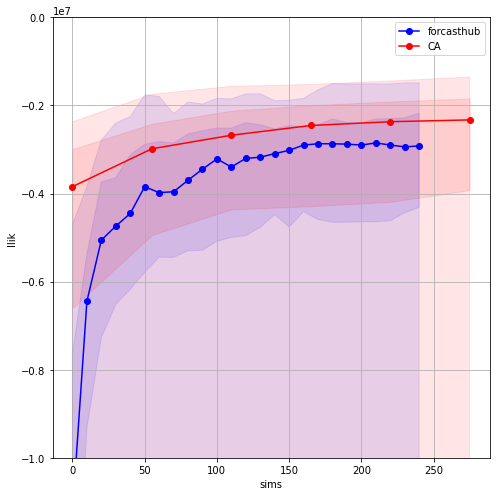

In [126]:
fig, axes = plt.subplots(1,1, figsize=(7,7), facecolor='white')
ax=axes
ax.grid()
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
ax.set_xlabel('sims')
ax.set_ylabel('llik')

colors = ['b', 'r', 'y', 'c']
i = 0

mult = {'CA': 55, 'forcasthub':10}

for name, result in resultST.items():
    full = result.groupby(['sim', 'slot']).sum().reset_index()
    full = full.pivot(index='sim', columns='slot', values='ll')
    #ax.plot(full, lw = .6, alpha = .5)
    ax.fill_between((full.index-1)*mult[name], full.quantile(.025, axis = 1), full.quantile(.975, axis = 1), alpha = .1, color = colors[i])
    ax.fill_between((full.index-1)*mult[name], full.quantile(.25, axis = 1), full.quantile(.75, axis = 1), alpha = .1, color = colors[i])
    ax.plot((full.index-1)*mult[name], full.median(axis=1), marker = 'o', label = name, color = colors[i])
    i += 1
ax.legend()
ax.set_ylim(-1e7, 0)


fig.tight_layout()

## 2. hpar

In [159]:
max_f = -1
for name, path in all_runs_path.items():
    file_list = glob.glob(path + "**/hpar/**/intermediate/*.parquet", recursive=True)
    file_list.sort()
    file_list = file_list[:max_f]
    print(name, len(file_list))
    all_runs[name] = file_list 

forcasthub 2474
CA 593


In [161]:
st = 'CA'
st = 'forcasthub'
filename = all_runs[st][2000]
df_csv = pq.read_table(filename).to_pandas()               
df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
df_csv['ID'] = st
df_csv = df_csv[df_csv['geoid'].isin(keep)]
#df_csv = df_csv[(df_csv['outcome'] == 'incidC') & (df_csv['quantity'] == 'probability')& (df_csv['p_comp'] == 0.0)]
df_csv = df_csv[(df_csv['outcome'] == 'incidC')]
#df_csv = df_csv.groupby(['slot','sim', 'ID']).median().reset_index()
#df_csv = df_csv[['value','sim', 'slot', 'ID']]
df_csv

,geoid,p_comp,quantity,outcome,source,value,slot,sim,ID
34658,06003,0.0,probability,incidC,incidI,0.173978,81,1,forcasthub
34799,06091,0.0,probability,incidC,incidI,0.157940,81,1,forcasthub
35297,06049,0.0,probability,incidC,incidI,0.284115,81,1,forcasthub
35558,06105,0.0,probability,incidC,incidI,0.235734,81,1,forcasthub
35600,06051,0.0,probability,incidC,incidI,0.272195,81,1,forcasthub
...,...,...,...,...,...,...,...,...,...
40894,06071,0.0,delay,incidC,incidI,7.000000,81,1,forcasthub
40895,06065,0.0,delay,incidC,incidI,7.000000,81,1,forcasthub
40900,06059,0.0,delay,incidC,incidI,7.000000,81,1,forcasthub
40901,06073,0.0,delay,incidC,incidI,7.000000,81,1,forcasthub


In [ ]:
df

In [144]:
#@dask.delayed
def read_and_label_snpi(filename, st):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['ID'] = st
    df_csv = df_csv[df_csv['geoid'].isin(keep)]
    df_csv = df_csv[(df_csv['outcome'] == 'incidC') & (df_csv['quantity'] == 'probability')& (df_csv['p_comp'] == 0.0)]
    df_csv = df_csv.groupby(['slot','sim', 'ID']).median().reset_index()
    df_csv = df_csv[['value','sim', 'slot', 'ID']]
    return df_csv

resultST = {}

for name, file_list in all_runs.items():
    # create a list of functions ready to return a pandas.DataFrame
    dfs = [delayed(read_and_label_snpi)(fname, name) for fname in file_list]
    # using delayed, assemble the pandas.DataFrames into a dask.DataFrame
    ddfST = dd.from_delayed(dfs)
    postST = ddfST.groupby(['sim','slot','ID']).sum().compute(scheduler="threads")
    postST =  postST.reorder_levels(['ID','slot','sim']).sort_index().reset_index()
    resultST[name] = postST

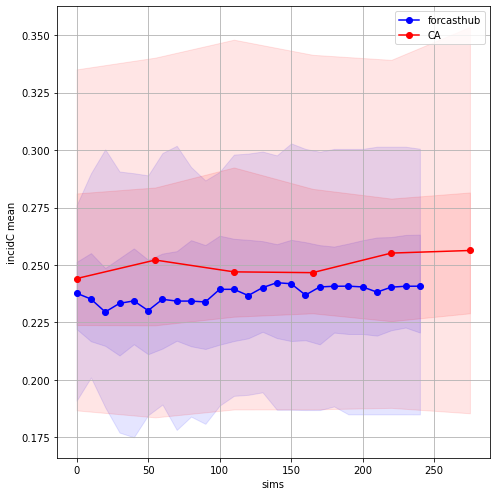

In [145]:
fig, axes = plt.subplots(1,1, figsize=(7,7), facecolor='white')
ax=axes
ax.grid()
#ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
ax.set_xlabel('sims')
ax.set_ylabel('incidC mean')

colors = ['b', 'r', 'y', 'c']
i = 0

#mult = {'CA': 55, 'forcasthub':10}

for name, result in resultST.items():
    full = result.groupby(['sim', 'slot']).sum().reset_index()
    full = full.pivot(index='sim', columns='slot', values='value')
    #ax.plot(full, lw = .6, alpha = .5)
    ax.fill_between((full.index-1)*mult[name], full.quantile(.025, axis = 1), full.quantile(.975, axis = 1), alpha = .1, color = colors[i])
    ax.fill_between((full.index-1)*mult[name], full.quantile(.25, axis = 1), full.quantile(.75, axis = 1), alpha = .1, color = colors[i])
    ax.plot((full.index-1)*mult[name], full.median(axis=1), marker = 'o', label = name, color = colors[i])
    i += 1
ax.legend()


fig.tight_layout()

In [164]:
np.arange(0)

array([], dtype=int64)

In [7]:
#@dask.delayed
def read_and_label_hosp(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['state'] = state_append
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['state', 'time', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['incidC','sim', 'slot', 'state', 'time']]
    df_csv = pd.merge(df_csv, truth, on=['time', 'state'], how='inner')
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_hosp)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)

In [ ]:
ddf['errorC_abs'] = np.abs((ddf['incidC'] - ddf['incidC_T']))
ddf['errorC_rel'] = np.abs((ddf['incidC'] - ddf['incidC_T'])/ddf['incidC_T'])
ddf = ddf.replace([np.inf, -np.inf], np.nan)

In [8]:
post = ddf.groupby(['sim','slot','state']).mean().compute(scheduler="threads")  #much faster than scheduler="processes" and other alternatives #ddf = client.persist(ddf), client.compute, 

In [9]:
#ddf.visualize(rankdir='LR')

In [10]:
post =  post.reorder_levels(['state','slot','sim']).sort_index().reset_index()

In [11]:
fig, axes = plt.subplots(5,11, figsize=(30,10))

for i, ax in enumerate(axes.flat):
    sn = post['state'].unique()[i]
    st = post[post['state'] == sn].pivot(index='sim', columns='slot', values='errorC_abs')
    #ax.plot(st, lw = .5)
    #ax.plot(st.quantile(.5, axis = 1), lw = 1)
    ax.plot(st.mean(axis = 1), lw = 1)#, marker = '.')
    ax.set_title(sn)
    #ax.set_ylim(0,1000)

In [ ]:
full = post.groupby(['sim', 'slot']).sum().reset_index()

full.pivot(index='sim', columns='slot', values='errorC_rel').plot(legend=False)
full.pivot(index='sim', columns='slot', values='errorC_abs').plot(legend=False)
#post.to_csv('USA-20201109T013836-hosp.csv')

In [15]:
max_f = 5

file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]

def read_and_label_CA(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['state'] = 'CA'
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['state', 'time', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['incidC','sim', 'slot', 'state', 'time']]
    df_csv = pd.merge(df_csv, truth[truth['state']=='CA'], on=['time', 'state'], how='inner')
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfsS = [delayed(read_and_label_CA)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfS = dd.from_delayed(dfsS)

In [16]:
ddfS['errorC_abs'] = np.abs((ddfS['incidC'] - ddfS['incidC_T']))
ddfS['errorC_rel'] = np.abs((ddfS['incidC'] - ddfS['incidC_T'])/ddfS['incidC_T'])
ddfS = ddfS.replace([np.inf, -np.inf], np.nan)

In [17]:
postS = ddfS.groupby(['sim','slot','state']).mean().compute(scheduler="threads") 

In [18]:
postS =  postS.reorder_levels(['state','slot','sim']).sort_index().reset_index()

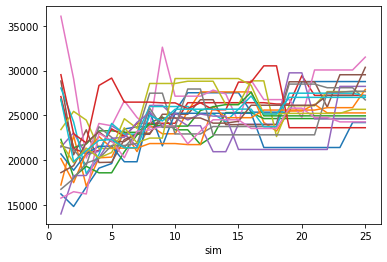

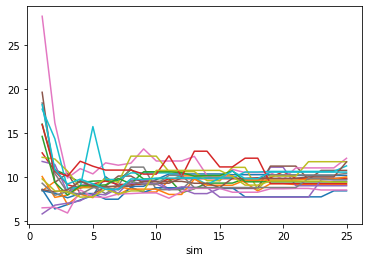

In [19]:
postS.pivot(index='sim', columns='slot', values='errorC_abs').plot(legend=False)
postS.pivot(index='sim', columns='slot', values='errorC_rel').plot(legend=False)

In [5]:
max_f = -1
path = r'state_analysis/usa' # use your path
#path = r'CA/intermediate' # use your path
file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]

In [17]:
#@dask.delayed
def read_and_label_llik(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    #df_csv['state'] = state_append
    df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['USPS', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['ll','sim', 'slot', 'USPS']]
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_llik)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfL = dd.from_delayed(dfs)

In [12]:
postL = ddfL.groupby(['sim','slot','USPS']).sum().compute(scheduler="threads")

In [13]:
postL =  postL.reorder_levels(['USPS','slot','sim']).sort_index().reset_index()

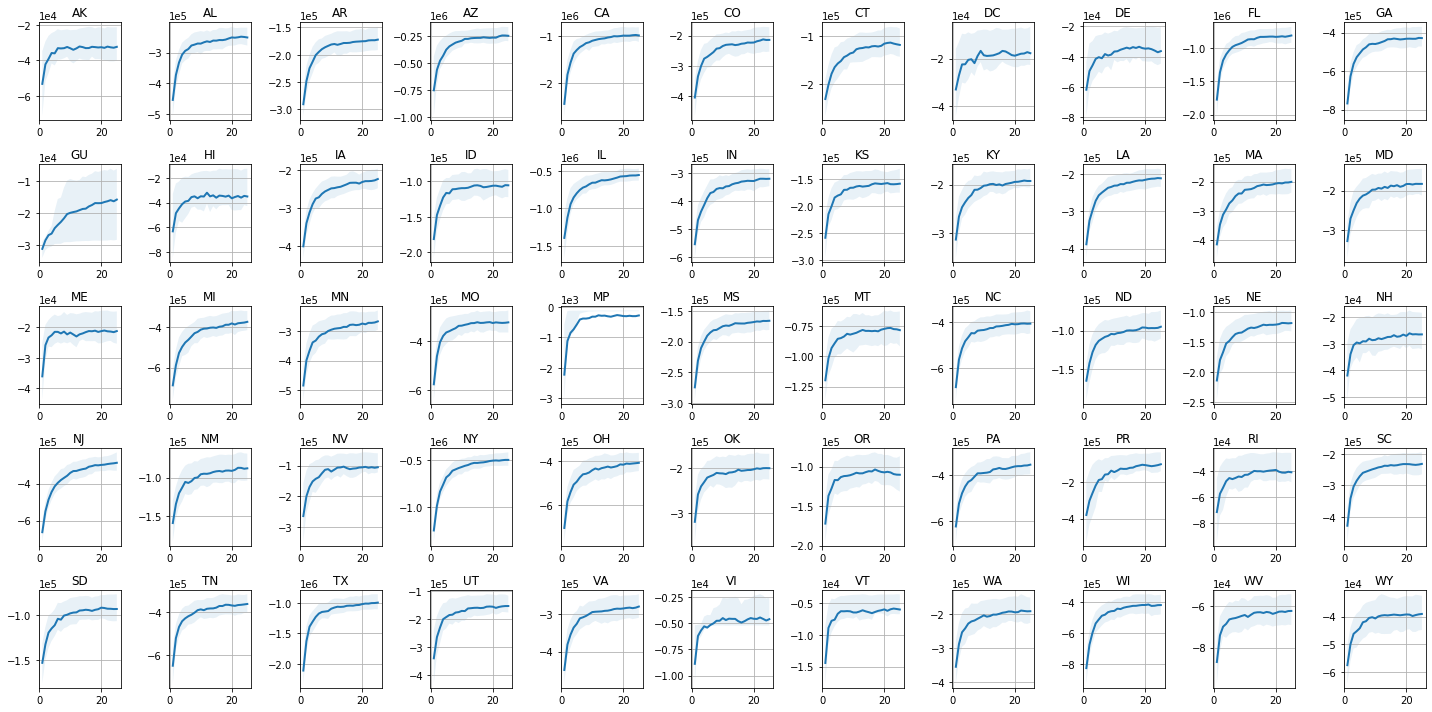

In [116]:
fig, axes = plt.subplots(5,11, figsize=(20,10), facecolor='white')#, sharey=True)

for i, ax in enumerate(axes.flat):
    sn = postL['USPS'].unique()[i]
    st = postL[postL['USPS'] == sn].pivot(index='sim', columns='slot', values='ll')
    #ax.plot(st, lw = .5)
    ax.fill_between(st.index, st.quantile(.25, axis = 1), st.quantile(.75, axis = 1), alpha = .1)
    ax.plot(st.mean(axis =1 ), lw = 2)#, marker = '.')
    ax.set_title(sn)
    ax.grid()
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    #ax.set_ylim(-400000,0)
    #ax.set_xlim(10,25)
fig.tight_layout()

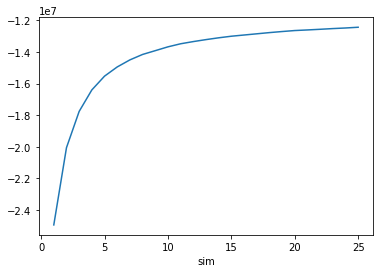

In [140]:
full = postL.groupby(['sim', 'slot']).sum().reset_index()

full.pivot(index='sim', columns='slot', values='ll').mean(axis=1).plot(legend=False)

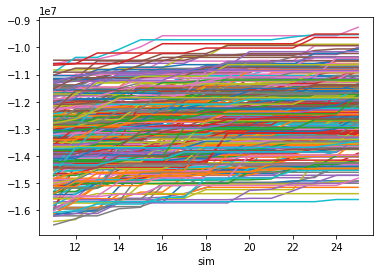

In [141]:
full.pivot(index='sim', columns='slot', values='ll')[10:25].plot(legend=False)

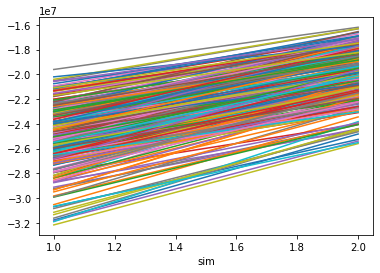

In [142]:
full.pivot(index='sim', columns='slot', values='ll')[0:2].plot(legend=False)

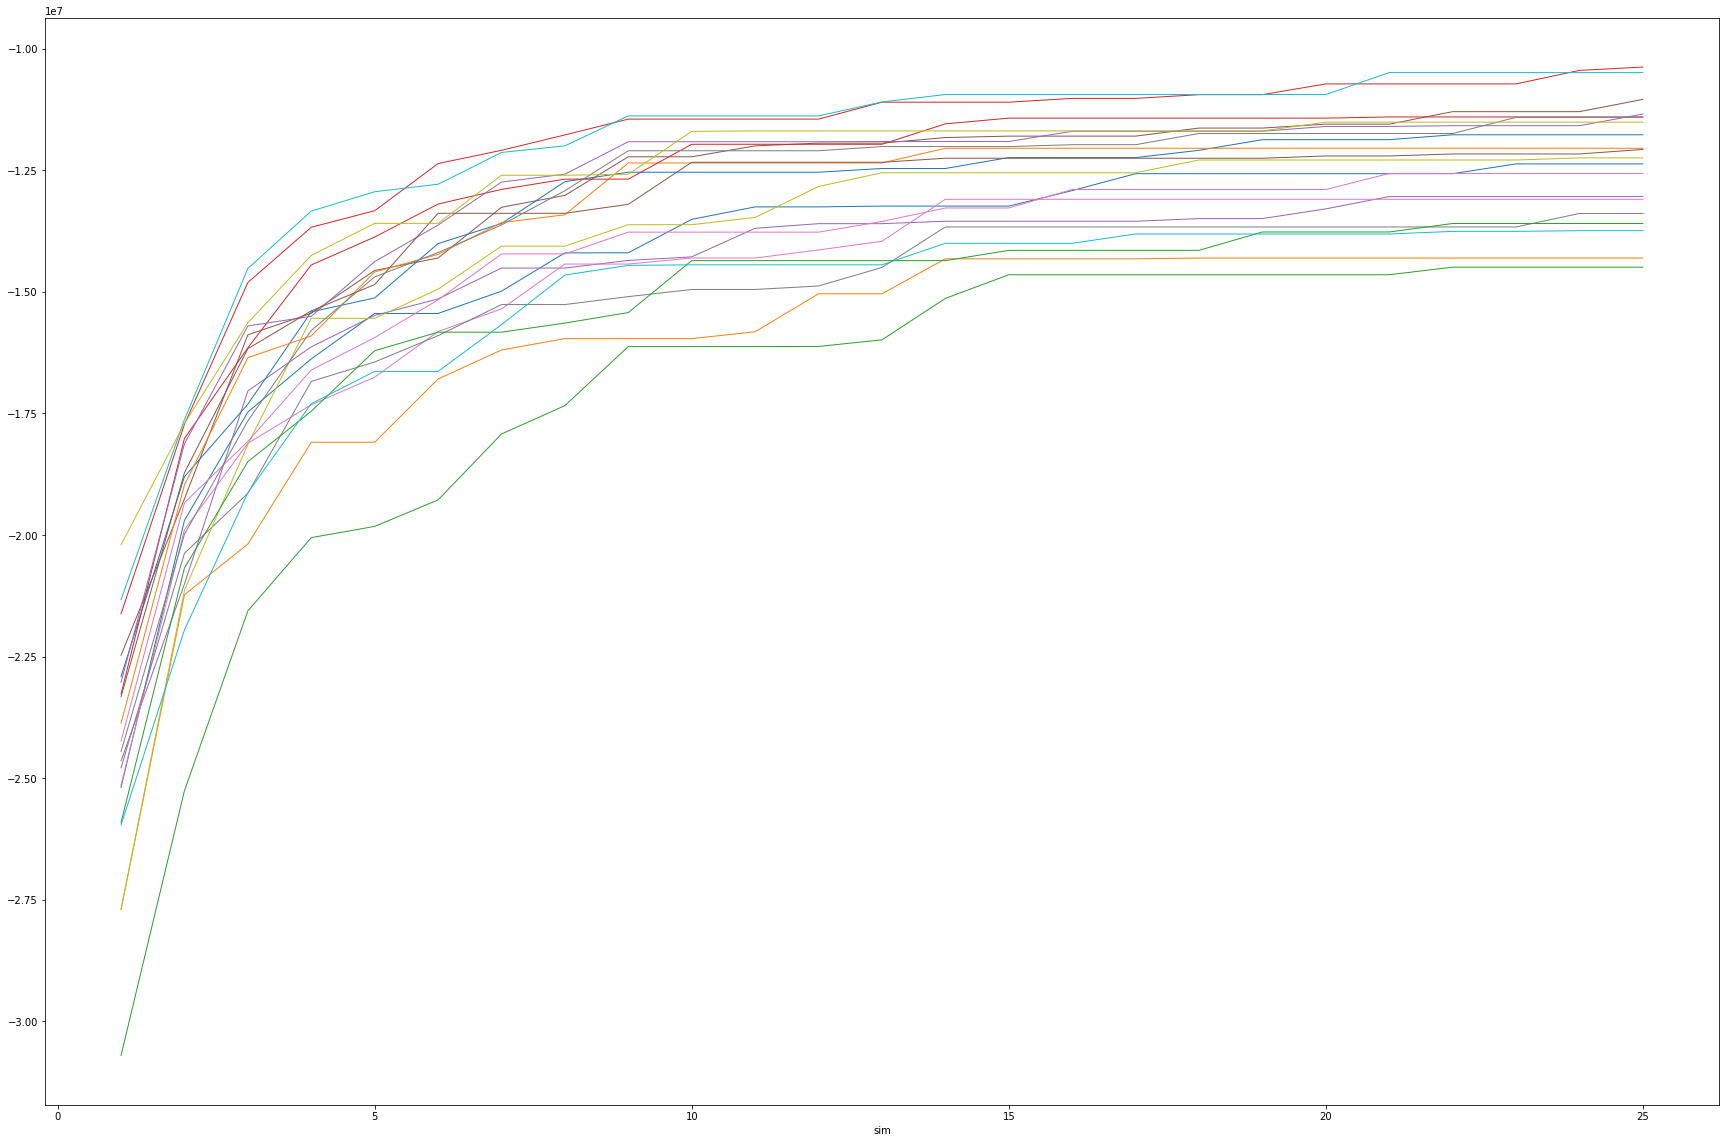

In [148]:
full.pivot(index='sim', columns='slot', values='ll').iloc[:,::15].plot(legend=False,linewidth = 1, figsize=(30,20))
#full.pivot(index='sim', columns='slot', values='ll').mean(axis=1)[10:25].plot(legend=False)

In [16]:
states = ['AK', 'AZ','SD', 'WI']

In [28]:
full

slot,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
sim,,,,,,,,,,,,,,,,,,,,,
1,-2.432678e+07,-2.439142e+07,-2.428541e+07,-2.389619e+07,-2.276652e+07,-2.443479e+07,-2.458209e+07,-2.458542e+07,-2.451539e+07,-2.429413e+07,...,-2.438279e+07,-2.442318e+07,-2.441178e+07,-2.457961e+07,-2.455497e+07,-2.454716e+07,-2.436020e+07,-2.427267e+07,-2.435954e+07,-2.478888e+07
2,-2.431102e+07,-2.398273e+07,-2.421741e+07,-2.378718e+07,-2.272116e+07,-2.416991e+07,-2.418704e+07,-2.409676e+07,-2.421724e+07,-2.394260e+07,...,-2.438279e+07,-2.408054e+07,-2.407711e+07,-2.419192e+07,-2.418947e+07,-2.428224e+07,-2.429402e+07,-2.393263e+07,-2.409933e+07,-2.430137e+07
3,-2.410547e+07,-2.394593e+07,-2.404997e+07,-2.377484e+07,-2.249722e+07,-2.405256e+07,-2.417292e+07,-2.402086e+07,-2.421724e+07,-2.394260e+07,...,-2.419385e+07,-2.403783e+07,-2.378031e+07,-2.406927e+07,-2.412076e+07,-2.428224e+07,-2.420110e+07,-2.383524e+07,-2.398836e+07,-2.424257e+07
4,-2.410547e+07,-2.377955e+07,-2.404997e+07,-2.365882e+07,-2.249722e+07,-2.391193e+07,-2.400356e+07,-2.402086e+07,-2.405502e+07,-2.389678e+07,...,-2.399237e+07,-2.378445e+07,-2.374879e+07,-2.406927e+07,-2.411505e+07,-2.424511e+07,-2.397098e+07,-2.382548e+07,-2.395751e+07,-2.416359e+07
5,-2.407277e+07,-2.377955e+07,-2.398385e+07,-2.363811e+07,-2.249722e+07,-2.391193e+07,-2.400356e+07,-2.390007e+07,-2.405502e+07,-2.371780e+07,...,-2.399237e+07,-2.378445e+07,-2.374879e+07,-2.406927e+07,-2.393276e+07,-2.414494e+07,-2.394657e+07,-2.359790e+07,-2.383572e+07,-2.412586e+07
6,-2.407277e+07,-2.371709e+07,-2.398385e+07,-2.362800e+07,-2.238042e+07,-2.391193e+07,-2.387008e+07,-2.387918e+07,-2.402575e+07,-2.371780e+07,...,-2.399237e+07,-2.378445e+07,-2.374879e+07,-2.406927e+07,-2.393276e+07,-2.410903e+07,-2.382015e+07,-2.359790e+07,-2.383572e+07,-2.407820e+07
7,-2.406571e+07,-2.365880e+07,-2.398385e+07,-2.362800e+07,-2.228423e+07,-2.391193e+07,-2.387008e+07,-2.387918e+07,-2.402575e+07,-2.371780e+07,...,-2.396175e+07,-2.378445e+07,-2.374879e+07,-2.404409e+07,-2.383382e+07,-2.403368e+07,-2.382015e+07,-2.359790e+07,-2.381978e+07,-2.404549e+07
8,-2.406571e+07,-2.359710e+07,-2.392215e+07,-2.356078e+07,-2.228423e+07,-2.388114e+07,-2.387008e+07,-2.387918e+07,-2.402575e+07,-2.366006e+07,...,-2.396175e+07,-2.370197e+07,-2.374879e+07,-2.401216e+07,-2.383382e+07,-2.403368e+07,-2.382015e+07,-2.351533e+07,-2.381978e+07,-2.401781e+07
9,-2.406260e+07,-2.354294e+07,-2.392215e+07,-2.350811e+07,-2.215403e+07,-2.378601e+07,-2.387008e+07,-2.387918e+07,-2.398166e+07,-2.355294e+07,...,-2.396175e+07,-2.370197e+07,-2.370579e+07,-2.401019e+07,-2.383382e+07,-2.403368e+07,-2.382015e+07,-2.337559e+07,-2.375681e+07,-2.401781e+07


In [1]:
comp = 'S'
def read_and_label_seir_st(filename, st):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv = df_csv[df_csv['comp']==comp].set_index('time', drop=True).drop('comp',axis = 1).sum(axis=1)
    df_csv = pd.DataFrame(df_csv)
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    return df_csv

In [9]:
path = f'state_analysis/SDseirOther'
file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]
sn = 'SD'
# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_seir_st)(fname, sn) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfSE = dd.from_delayed(dfs)

In [10]:
postSE = ddfSE.compute(scheduler="threads")

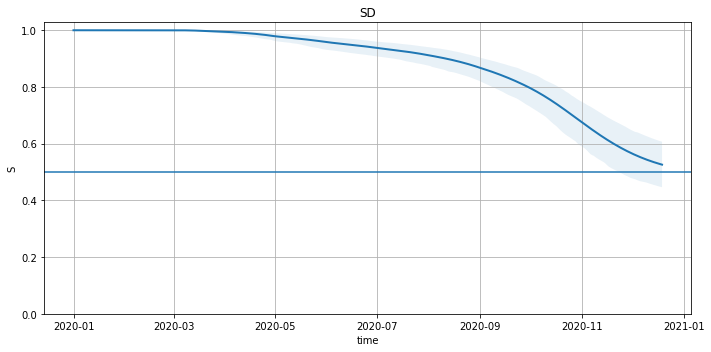

In [12]:
fig, axes = plt.subplots(1,1, figsize=(10,5), facecolor='white')

ax = axes
st = postSE.pivot(columns='slot', values=0)
st = st/max(st[1])

ax.fill_between(st.index, st.quantile(.05, axis = 1), st.quantile(.95, axis = 1), alpha = .1)
ax.plot(st.mean(axis = 1 ), lw = 2,  label = 'nation')
ax.set_title(sn)
ax.axhline(.50)

ax.grid()
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
ax.set_ylim(0)
ax.set_xlabel('time')
ax.set_ylabel(comp)
    
fig.tight_layout()